# Hospital Readmissions EDA

This notebook explores patterns in discharge dates, readmission timing, medical conditions, and patient behavior.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../data/hospital_readmissions_2000.csv")
df.head()


Matplotlib is building the font cache; this may take a moment.


,encounter_id,patient_name,dob,date_of_admission,date_of_discharge,date_of_readmission,primary_medical_condition,secondary_medical_condition,measure_name
0,1,Franklin Scott,5/6/1983,7/17/2024,7/21/2024,NaN,Pregnancy-related complication,NaN,No readmission
1,2,Zoe Brown,4/22/1975,9/23/2024,9/28/2024,10/19/2024,Congestive heart failure,Acute kidney injury,Stroke registry
2,3,Peter Carter,7/16/2003,4/15/2024,4/25/2024,5/5/2024,Asthma,Anxiety,90-day all-cause readmission
3,4,Yasmin Garcia,2/22/1992,3/20/2024,3/26/2024,NaN,Type 2 diabetes,Type 2 diabetes,Stroke registry
4,5,Caroline Green,8/4/1992,5/17/2025,5/24/2025,6/3/2025,Type 2 diabetes,Acute kidney injury,30-day BH readmission


In [2]:
df.shape

(2000, 9)

In [3]:
df.columns

Index(['encounter_id', 'patient_name', 'dob', 'date_of_admission',
       'date_of_discharge', 'date_of_readmission', 'primary_medical_condition',
       'secondary_medical_condition', 'measure_name'],
      dtype='object')

In [4]:
df.isna().sum().sort_values(ascending=False).head(10)

date_of_readmission            1262
secondary_medical_condition     159
date_of_discharge                95
encounter_id                      0
patient_name                      0
dob                               0
date_of_admission                 0
primary_medical_condition         0
measure_name                      0
dtype: int64

In [5]:
# Parse dates
df["date_of_discharge"] = pd.to_datetime(df["date_of_discharge"], errors="coerce")
df["date_of_readmission"] = pd.to_datetime(df["date_of_readmission"], errors="coerce")

# Days between discharge and readmission
df["days_to_readmission"] = (df["date_of_readmission"] - df["date_of_discharge"]).dt.days

# Flags
df["readmitted_flag"] = df["date_of_readmission"].notna().astype(int)
df["readmitted_30_flag"] = (
    (df["days_to_readmission"].between(0, 30)) & (df["date_of_readmission"].notna())
).astype(int)

# Discharge month
df["discharge_month"] = df["date_of_discharge"].dt.to_period("M").astype(str)

df[["date_of_discharge","date_of_readmission","days_to_readmission","readmitted_30_flag","discharge_month"]].head()


,date_of_discharge,date_of_readmission,days_to_readmission,readmitted_30_flag,discharge_month
0,2024-07-21,NaT,NaN,0,2024-07
1,2024-09-28,2024-10-19,21.0,1,2024-09
2,2024-04-25,2024-05-05,10.0,1,2024-04
3,2024-03-26,NaT,NaN,0,2024-03
4,2025-05-24,2025-06-03,10.0,1,2025-05


In [17]:
df_valid["readmitted_7_flag"] = (
    (df_valid["days_to_readmission"] >= 0) &
    (df_valid["days_to_readmission"] <= 7)
).astype(int)

df_valid[[
    "patient_name",
    "days_to_readmission",
    "readmitted_7_flag",
    "readmitted_30_flag"
]].head()


,patient_name,days_to_readmission,readmitted_7_flag,readmitted_30_flag
0,Franklin Scott,NaN,0,0
1,Zoe Brown,21.0,0,1
2,Peter Carter,10.0,0,1
3,Yasmin Garcia,NaN,0,0
4,Caroline Green,10.0,0,1


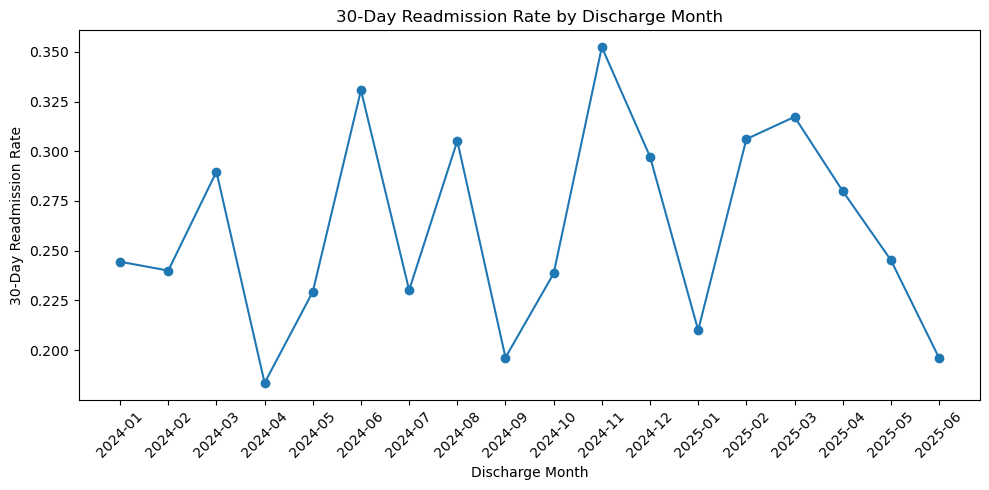

In [12]:
df_valid["discharge_month"] = df_valid["date_of_discharge"].dt.to_period("M").astype(str)

monthly = (
    df_valid.groupby("discharge_month")["readmitted_30_flag"]
    .agg(total_discharges="count", readmitted_30="sum")
    .reset_index()
)

monthly["readmission_rate_30"] = monthly["readmitted_30"] / monthly["total_discharges"]
monthly = monthly.sort_values("discharge_month")

plt.figure(figsize=(10, 5))
plt.plot(monthly["discharge_month"], monthly["readmission_rate_30"], marker="o")
plt.title("30-Day Readmission Rate by Discharge Month")
plt.xlabel("Discharge Month")
plt.ylabel("30-Day Readmission Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [13]:
df_valid["discharge_month"] = df_valid["date_of_discharge"].dt.to_period("M").astype(str)

monthly = (
    df_valid.groupby("discharge_month")["readmitted_30_flag"]
    .agg(total_discharges="count", readmitted_30="sum")
    .reset_index()
)

monthly["readmission_rate_30"] = monthly["readmitted_30"] / monthly["total_discharges"]
monthly = monthly.sort_values("discharge_month")


In [15]:
condition_summary = (
    df_valid.groupby("primary_medical_condition")["readmitted_30_flag"]
    .agg(total_discharges="count", readmitted_30="sum")
    .reset_index()
)

condition_summary["readmission_rate_30"] = (
    condition_summary["readmitted_30"] / condition_summary["total_discharges"]
)

condition_summary = condition_summary.sort_values(
    "readmission_rate_30", ascending=False
)

condition_summary.head(10)


,primary_medical_condition,total_discharges,readmitted_30,readmission_rate_30
0,Asthma,133,42,0.315789
3,COPD,126,39,0.309524
8,Myocardial infarction,126,38,0.301587
5,Congestive heart failure,147,42,0.285714
1,Back pain,142,40,0.281690
10,Pregnancy-related complication,140,39,0.278571
6,Heart failure,102,28,0.274510
14,Type 2 diabetes,123,31,0.252033
4,Chronic kidney disease,136,34,0.250000
2,Breast cancer,120,29,0.241667


In [20]:
readmission_summary = pd.DataFrame({
    "7_day_readmission_rate": [
        df_valid["readmitted_7_flag"].sum() / df_valid.shape[0]
    ],
    "30_day_readmission_rate": [
        df_valid["readmitted_30_flag"].sum() / df_valid.shape[0]
    ]
})

readmission_summary


,7_day_readmission_rate,30_day_readmission_rate
0,0.108661,0.260892


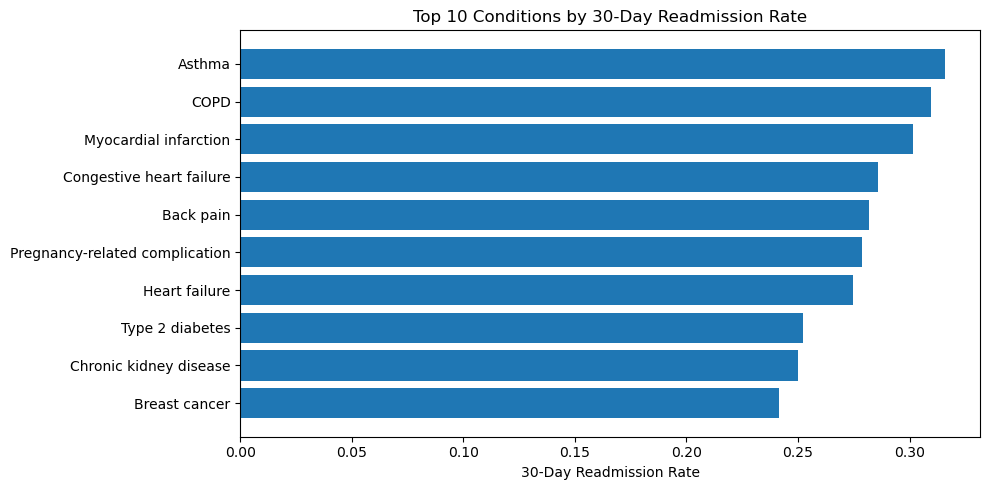

In [16]:
top_conditions = condition_summary.head(10)

plt.figure(figsize=(10, 5))
plt.barh(
    top_conditions["primary_medical_condition"],
    top_conditions["readmission_rate_30"]
)
plt.xlabel("30-Day Readmission Rate")
plt.title("Top 10 Conditions by 30-Day Readmission Rate")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [18]:
df_valid["readmitted_7_flag"] = (
    (df_valid["days_to_readmission"] >= 0) &
    (df_valid["days_to_readmission"] <= 7)
).astype(int)

df_valid[[
    "patient_name",
    "days_to_readmission",
    "readmitted_7_flag",
    "readmitted_30_flag"
]].head()


,patient_name,days_to_readmission,readmitted_7_flag,readmitted_30_flag
0,Franklin Scott,NaN,0,0
1,Zoe Brown,21.0,0,1
2,Peter Carter,10.0,0,1
3,Yasmin Garcia,NaN,0,0
4,Caroline Green,10.0,0,1


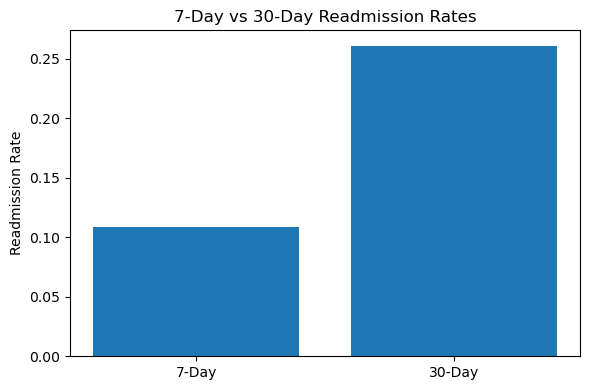

In [21]:
plt.figure(figsize=(6,4))
plt.bar(
    ["7-Day", "30-Day"],
    [
        readmission_summary["7_day_readmission_rate"][0],
        readmission_summary["30_day_readmission_rate"][0]
    ]
)
plt.ylabel("Readmission Rate")
plt.title("7-Day vs 30-Day Readmission Rates")
plt.tight_layout()
plt.show()


In [22]:
readmission_summary.style.format("{:.1%}")


,7_day_readmission_rate,30_day_readmission_rate
0,10.9%,26.1%
